# Implementing Contextual Thompson Sampling For MovieLens 100k Datasaet


### Initialization python envirnment


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import random
import statistics
import matplotlib.pyplot as plt
rng = np.random.default_rng()




### Loading the data and define train and test data

In [9]:
item_file = 'ml-100k/u.item'
user_file = 'ml-100k/u.user'
rating_file = 'ml-100k/u.data'


item_cols = [
    'movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
] + [f'genre_{i}' for i in range(19)]  # 19 genres

rating_cols = ['user_id', 'movie_id', 'rating', 'timestamp']

user_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']

items = pd.read_csv(item_file, sep='|', encoding='latin-1', names=item_cols, header=None)
users = pd.read_csv(user_file, sep='|', names=user_cols, header=None)

ratings = pd.read_csv(rating_file, sep='\t', names=rating_cols, header=None)

#  sorting ratings by timestamp before splitting to simulate chronological learning:
ratings = ratings.sort_values(by='timestamp')

ix = int(len(ratings) * 0.8)
train = ratings.iloc[0:ix,:].copy()
test = ratings.iloc[ix:,:].copy()


For contextual thompson sampling and LinUCB since we are using a model, we should frist prepare the features as input to the model. We use both user and movie features as input to the model.  

In [10]:
# bins user ages
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, np.inf]
labels = range(len(bins)-1)
users['age_bucket'] = pd.cut(users['age'], bins=bins, labels=labels, right=False)
age_ohe = pd.get_dummies(users['age_bucket'], prefix='age')
users = pd.concat([users, age_ohe], axis=1)
# ensure everything is numeric
users[age_ohe.columns] = users[age_ohe.columns].astype(int)


# creates a one-hot encoding for M, F, and any potential missing values.
gender_dummies = pd.get_dummies(users['gender'], prefix='gender')
users = pd.concat([users, gender_dummies], axis=1)


#occupation
occupation_ohe = pd.get_dummies(users['occupation'], prefix='occ')
users = pd.concat([users, occupation_ohe], axis=1)
# ensure everything is numeric
users[occupation_ohe.columns] = users[occupation_ohe.columns].astype(int)


#zip_code
# we apply smooth target encoding, it should be on training data only
train_rating_user = train.merge(users, on='user_id', how='left')
test_rating_user = test.merge(users, on='user_id', how='left')
zip_code_stats = train_rating_user.groupby('zip_code')['rating'].agg(['count', 'mean']).reset_index()
global_mean = np.mean(train['rating'])
m = 20

def apply_smooth_target_encoding(df):
    
    merged_df = pd.merge(df[['zip_code']], zip_code_stats,  on = 'zip_code', how='left')
    merged_df['count'] = merged_df['count'].fillna(0)
    merged_df['mean'] = merged_df['mean'].fillna(global_mean)
    
    zip_code_encoded = (merged_df['count']*merged_df['mean'] + m * global_mean)/(merged_df['count']+m)
    return zip_code_encoded
    
    

train_rating_user['encoded_zip_code'] = apply_smooth_target_encoding(train_rating_user)
test_rating_user['encoded_zip_code'] = apply_smooth_target_encoding(test_rating_user)

############### Adding movie features to context ################

train_rating_user_movie = train_rating_user.merge(items, on='movie_id', how='left')
test_rating_user_movie = test_rating_user.merge(items, on='movie_id', how='left')

# age of movie feature: timestamp - release year
train_rating_user_movie['rating_year'] = pd.to_datetime(train_rating_user_movie['timestamp'], unit='s').dt.year
test_rating_user_movie['rating_year'] = pd.to_datetime(test_rating_user_movie['timestamp'], unit='s').dt.year


train_rating_user_movie['release_year'] = pd.to_datetime(train_rating_user_movie['release_date'], format='%d-%b-%Y').dt.year
test_rating_user_movie['release_year'] = pd.to_datetime(test_rating_user_movie['release_date'], format='%d-%b-%Y').dt.year





train_rating_user_movie['movie_age'] = train_rating_user_movie['rating_year'] - train_rating_user_movie['release_year']
test_rating_user_movie['movie_age'] = test_rating_user_movie['rating_year'] - test_rating_user_movie['release_year']


list_dropped_columns = ['timestamp', 'age', 'gender','occupation','zip_code','age_bucket','title', 'release_date','video_release_date','IMDb_URL','rating_year','release_year']


train_rating_user_movie = train_rating_user_movie.drop(columns = list_dropped_columns)
test_rating_user_movie = test_rating_user_movie.drop(columns = list_dropped_columns)

# Contextual Thompson Sampling with Shared Model

In CTS we can assume a linear reward model. At time step t, we observe context vector $x_{t,a}$:

$$r_{t,a} = x_{t,a}^T \theta_a + \text{noise}$$

We maintain posterior distribution over each $\theta_a$ (we use a shared parameter for all arms here). The posterior distribution is Guassian.

**Algorithm:**
1. initialize prior over $\theta \sim N(0,I)$, (we keep posterior $\theta \sim N(\mu, \Sigma)$)
2. For each round t=1,2,...,T:

    2.1.observe context $x_{t,a} \in R^d$ for each arm a
    
    2.2. sample $\bar{\theta} \sim N(\mu, \Sigma)$
    
    2.3. choose arm $a_t = \arg\max_a x_{t,a}^T \tilde{\theta_t}$
    
    2.4. observe reward $r_t$
    
    2.5. update posterior using Bayesian linear regression
    
    
#### Posterior update using Bayesian Linear Regression

We update the posterior parameters according to Bayes rule for Guassian distribution.

If we assume $\mu_0 = 0$ and $\Sigma_0 = \frac{1}{lambda} I$ as prior, we will update the posterior paramteres as below:

$$\Sigma_{posterior} = A^{-1}$$

$$\mu_{posterior} = \Sigma_{posterior} b= A^{-1} b$$

where:
$$A=X^TX + \lambda I$$

$$b = X^T y$$


In **Contextual Thompson Sampling**, we keep **A** and **b** updated online:

$A = A + x_t x_t^T$

$b = b + r_t x_t$


In [11]:
# Contextual Thompson Sampling class with Shared Model
class ContextualThompsonSampling:
    def __init__(self, arms, dim):
        self.arms = arms  # list of movie_ids
        self.dim = dim
        self.mean = np.zeros(dim) #posterior mean, 1 x dim
        self.sig = np.eye(dim) #posterior covariance, dim x dim
        self.lamb = 0.1
        self.A = self.lamb * np.eye(dim) # dim x dim
        self.b = np.zeros(dim) # 1 x dim or (dim,)

    def select_arm(self, contexts):
        """
        contexts: np.ndarray of shape (m, dim), row i = context for self.arms[i]
        returns: arm_id
        """
        
        theta = np.random.multivariate_normal(self.mean, self.sig) # 1 x dim or (dim,)
        
        scores = contexts @ theta # m x 1 or (m,)
        
        ix = np.argmax(scores)
        
        return ix
            


    def update(self, context, reward):
        """
        context: np.ndarray shape (dim,) for the arm you just played
        reward:  scalar
        """
        
        
        x = np.asarray(context, dtype=float).ravel()
        
        if not np.isfinite(x).all():
            # skip this update OR replace NaNs with 0
            x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
            
        self.A += np.outer(x, x) # X^T X accumulation
        self.b += reward * x # X^T y accumulation
        
        # Posterior: Σ = A^{-1}, μ = Σ b
        
        #solve: This function solves a system of linear equations in the form Ax = B,
        #where A is a square matrix, x is the unknown vector, and B is a known vector or matrix.
        # (use solve for numerical stability)
        
        #Solve is generally much faster and more numerically stable than calculating
        #the inverse of A and then multiplying it by B 
        self.sig  = np.linalg.solve(self.A, np.eye(self.dim)) 
        self.mean = np.linalg.solve(self.A, self.b)

    def get_posterior_mean_vector(self):
        return self.mean

                  

### Online Training
We simulate online interactions

In [12]:
import numpy as np

unique_arms = ratings['movie_id'].unique()

# ** Build list of feature columns (everything except ids and target)
# ** Make sure this matches the columns you intend to feed as context
feature_cols = [c for c in train_rating_user_movie.columns 
                if c not in ['user_id', 'movie_id', 'rating']]

# ** Dynamically set dim from feature_cols (avoid hard-coding like 53)
dim = len(feature_cols)

# ** (Optional but recommended) Shuffle user order to reduce ordering bias
unique_users = np.random.permutation(train_rating_user_movie['user_id'].unique())

cts = ContextualThompsonSampling(unique_arms, dim)

total_interactions = 0
total_rewards = 0

num_interactions_per_user = 3  # we can change this

for user_id in unique_users:
    # ** Work on a copy so we can drop picked rows (avoid re-recommending same row)
    user_rows = train_rating_user_movie[train_rating_user_movie['user_id'] == user_id].copy()

    for _ in range(num_interactions_per_user):
        # ** stop if this user has no remaining candidates
        if user_rows.empty:
            break

        # ** Extract candidate matrix Xcand as float ndarray with shape (m, dim)
        Xcand = user_rows[feature_cols].to_numpy(dtype=float)

        # select index into Xcand
        ix = cts.select_arm(Xcand)

        # ** Fetch reward from the matched row
        picked_row = user_rows.iloc[ix]
        reward = int(picked_row['rating'] >= 4)

        # ** Get the context vector corresponding to the chosen candidate
        x = Xcand[ix]  # shape (dim,)

        # update posterior
        cts.update(x, reward)

        total_rewards += reward
        total_interactions += 1

        # ** Remove the picked row so we don't pick it again for this user
        user_rows = user_rows.drop(user_rows.index[ix])

print(f"Total Interactions: {total_interactions}")
print(f"Total Reward (ratings ≥ 4): {total_rewards}")
print(f"Average Reward: {total_rewards / total_interactions:.4f}")


Total Interactions: 2251
Total Reward (ratings ≥ 4): 1429
Average Reward: 0.6348


## Precision@K


In [13]:

k = 5
precisions = []

for user in unique_users:
    # candidate movies for this user in test
    user_df = test_rating_user_movie[test_rating_user_movie['user_id'] == user].copy()
    if user_df.empty:
        continue

    X_user = user_df[feature_cols].to_numpy()

    # (Option A) deterministic ranking with posterior mean
    theta = cts.get_posterior_mean_vector()  # shape (dim,)
    scores = X_user @ theta

    # (Option B) stochastic: sample theta ~ N(mean, cov)
    # theta = np.random.multivariate_normal(ts.mean, ts.sig)
    # scores = X_user @ theta

    top_idx = np.argsort(scores)[-k:][::-1]
    top_movies = user_df.iloc[top_idx]

    # compute hits
    hits = (top_movies['rating'] >= 4).sum()
    denom = min(k, len(user_df))
    precisions.append(hits / denom)

precision_k = np.mean(precisions)
print(f"Precision@{k}: {precision_k:.4f}")

Precision@5: 0.5601


### Average cumulative rewards with simulation


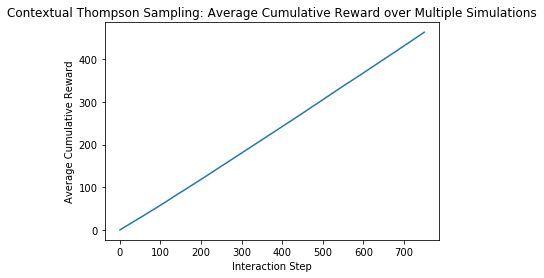

In [9]:
num_simulations = 100

    
all_runs = [] # stores cumulative rewards from each simulation

for sim in range(num_simulations):

    cts = ContextualThompsonSampling(unique_arms, dim)


    total_interactions = 0
    total_rewards = 0

    num_interactions_per_user = 1  # <--- you can change this number

    # To ensure diverse simulations, shuffle users in each run
    unique_users = np.random.permutation(train['user_id'].unique())

    cum_reward =[]
    cur_step = 0

    for user_id in unique_users:
        
        user_rows = train_rating_user_movie[train_rating_user_movie['user_id'] == user_id].copy()

        for _ in range(num_interactions_per_user):
            # ** stop if this user has no remaining candidates
            if user_rows.empty:
                break

            # ** Extract candidate matrix Xcand as float ndarray with shape (m, dim)
            Xcand = user_rows[feature_cols].to_numpy(dtype=float)

            # select index into Xcand
            ix = cts.select_arm(Xcand)

            # ** Fetch reward from the matched row
            picked_row = user_rows.iloc[ix]
            reward = int(picked_row['rating'] >= 4)

            # ** Get the context vector corresponding to the chosen candidate
            x = Xcand[ix]  # shape (dim,)

            # update posterior
            cts.update(x, reward)

            total_rewards += reward
            total_interactions += 1
            
            cum_reward.append(total_rewards)

            # ** Remove the picked row so we don't pick it again for this user
            user_rows = user_rows.drop(user_rows.index[ix])

    all_runs.append(cum_reward)


ave_cum_reward = np.mean(all_runs, axis=0)        
plt.plot(ave_cum_reward)

plt.title('Contextual Thompson Sampling: Average Cumulative Reward over Multiple Simulations')
plt.xlabel('Interaction Step')
plt.ylabel('Average Cumulative Reward')
plt.show()
